注意力机制<br>
注意力机制中的感官输入，放在神经网络中，可以理解为每一层神经网络的中间特征表示是一种感官输入。网络获得感官输入，网络输出结果，比如说分类的话，会输出各种类别。感官输入又被称为值。<br>
注意力机制分为两大类: <br>
第一种，是非自主性的注意力提示，这又被称为键。之前学过的全连接层、最大汇聚层都属于非自主性的注意力提示。每个值都与一个键匹配，非自主性注意力提示的神经网络经过训练，对感官输入进行学习，将值与键匹配。<br>
第二种，是自主性的注意力提示，这又被称为查询。通过设计注意力汇聚的方式，能匹配查询与键，用查询更好地引导出最匹配的值。

用比喻来理解注意力机制:<br>
感官输入是图书馆所有书籍的内容<br>
键是每本书的标签(如分类、作者)<br>
查询是用户的借书需求(如找一本和人工智能相关的书)，通过标签匹配，快速定位到相关书籍(值), 实现高效信息提取

Nadaraya-Waston核回归模型，可以用来演示具有注意力机制的机器学习<br>
$f(x) = \sum_{i=1}^{n}softmax(-\frac{1}{2}(x-x_i)^2)y_i$<br>
这里，$softmax(-\frac{1}{2}(x-x_i)^2)$可以理解为注意力权重，它是对查询x和键$x_i$之间关系的一种建模建立。这个权重将被分配给每个对应值$y_i$<br>
如果一个键$x_i$越接近给定的查询x, 那么分配给这个键的对应值$y_i$的注意力权重就越大，也就是获得了更多的注意力。

In [1]:
import torch 
from torch import nn 
from d2l import torch as d2l 

生成数据集

In [2]:
n_train = 50 # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本(排序为了后续更好可视化)
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, )) # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)                           # 测试样本， 50个
y_truth = f(x_test)                                        # 测试样本的真实输出
n_test = len(x_test)                                       # 测试样本数
n_test

50

In [3]:
def plot_kernel_reg(y_hat):
    """绘制所有加噪声的训练样本(圆圈), 不带噪声的真实函数及预测的函数"""
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5) # alpha=0.5 透明度50%

平均汇聚

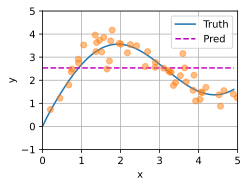

In [4]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test) # interleave, 每个元素可以指定重复次数
plot_kernel_reg(y_hat)

非参数注意力汇聚

感官输入(值): y_train<br>
自主性注意力提示(查询): x_test<br>
非自主性注意力提示(键): x_train<br>

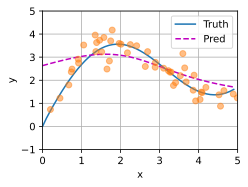

In [5]:
# X_repeat的形状为(n_test, n_train)
# 每一行都包含相同的测试输入(例如同样的查询)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含键.attention_weights的形状为(n_test, n_train)
# 每一行都包含要在给定的每个查询的值(y_train)之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

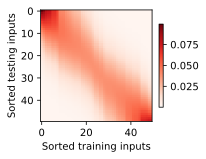

In [6]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), # unsqueeze增加维度
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

带参数注意力汇聚<br>
参数控制了高斯核区间的宽度，有的部分参考的邻近数据多些，有的部分参考的邻近数据少些。<br>
反映在拟合曲线上，曲线变得不那么平滑，但是更加贴合真实曲线<br>
它可以更好地利用数量较少的数据，学习出结果

In [7]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [8]:
weights = torch.ones((2, 10)) * 0.1 
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

定义模型

In [9]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True)) # 初始化权重
    
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询数， 键-值对数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries-keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询数， 键-值对数)
        return torch.bmm(self.attention_weights.unsqueeze(1), 
                         values.unsqueeze(-1)).reshape(-1)

训练<br>
任何一个训练样本的输入都会和除自身以外的所有训练样本的键-值对进行计算，从而得到其对应的预测输出

In [10]:
# X_tile的形状为(n_train, n_train), 每一行都包含相同的训练输入
X_tile = x_train.repeat((n_train, 1))  # 重复
# Y_tile的形状为(n_train, n_train), 每一行都包含相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状为('n_train', 'n_train'-1)
keys = X_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))  # 对角线不选中, 所以少一列
# values的形状为('n_train', 'n_train'-1)
values = Y_tile[(1-torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

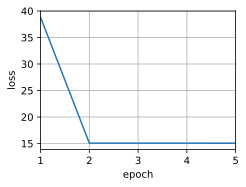

In [11]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch+1}, loss {float(l.sum())}:.6f')
    animator.add(epoch+1, float(l.sum()))

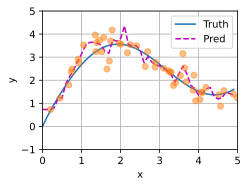

In [12]:
# 绘制拟合曲线
# keys的形状为(n_test, n_train)
# 每一行都包含相同的测试输入(例如同样的查询)
keys = x_train.repeat((n_test,1))
# value的形状为(n_test, n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

带参数的模型，曲线在注意力权重较大的区域变得更不平滑

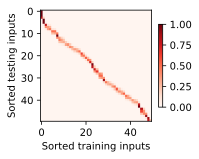

In [13]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')